In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import collections
import dscrutils2py as dscrutils
import dscutils

import matplotlib.pyplot as plt
import mpl_stylesheet
import mpl_utils
import plot_meta
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 300)

In [2]:
dsc_outdir = os.path.realpath("../dsc/dsc_result")
methods = ["ridge", "lasso", "lasso_1se", "elastic_net",
           "elastic_net_1se", "l0learn", "scad", "mcp", 
           "susie", "varbvs", "varbvsmix", "blasso", "bayesb",
           "mr_ash", "mr_ash_init"]
dims = (500, 200)
sfracs = [0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1.0]
targets = ["simulate", "simulate.dims", "simulate.se", "simulate.sfrac", "simulate.pve", "fit", "mse.err"]
sim_scenario = "indepgauss"

In [3]:
conditions = [f"$(simulate.dims) == '({dims[0]},{dims[1]})'", 
              f"$(simulate) == '{sim_scenario}'"]

dscout = dscrutils.dscquery(dsc_outdir, targets, conditions = conditions)
dscout['score1'] = np.sqrt(dscout['mse.err'])/dscout['simulate.se']

INFO: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


Calling: dsc-query /home/saikat/Documents/work/ebmr/simulation/mr-ash-dsc/dsc/dsc_result -o /tmp/RtmpC7RBCv/file4c68a1ef21e37.csv --target "simulate simulate.dims simulate.se simulate.sfrac simulate.pve fit mse.err" --force 
Loaded dscquery output table with 4200 rows and 10 columns.



In [4]:
dscout

,DSC,simulate,simulate.dims,simulate.se,simulate.sfrac,simulate.pve,fit,mse.err,score1
0,1,indepgauss,"(500,200)",3.462448,0.010,0.50,l0learn,12.563997,1.023719
1,1,indepgauss,"(500,200)",1.905777,0.025,0.50,l0learn,3.574130,0.992003
2,1,indepgauss,"(500,200)",3.063747,0.050,0.50,l0learn,9.284629,0.994556
3,1,indepgauss,"(500,200)",4.998240,0.100,0.50,l0learn,25.215058,1.004646
4,1,indepgauss,"(500,200)",7.226967,0.250,0.50,l0learn,58.729739,1.060408
...,...,...,...,...,...,...,...,...,...
4195,20,indepgauss,"(500,200)",1.037678,0.050,0.95,mcp,1.193164,1.052659
4196,20,indepgauss,"(500,200)",1.059163,0.100,0.95,mcp,1.229750,1.046998
4197,20,indepgauss,"(500,200)",1.763548,0.250,0.95,mcp,3.749849,1.098044
4198,20,indepgauss,"(500,200)",2.206727,0.500,0.95,mcp,6.815372,1.183031


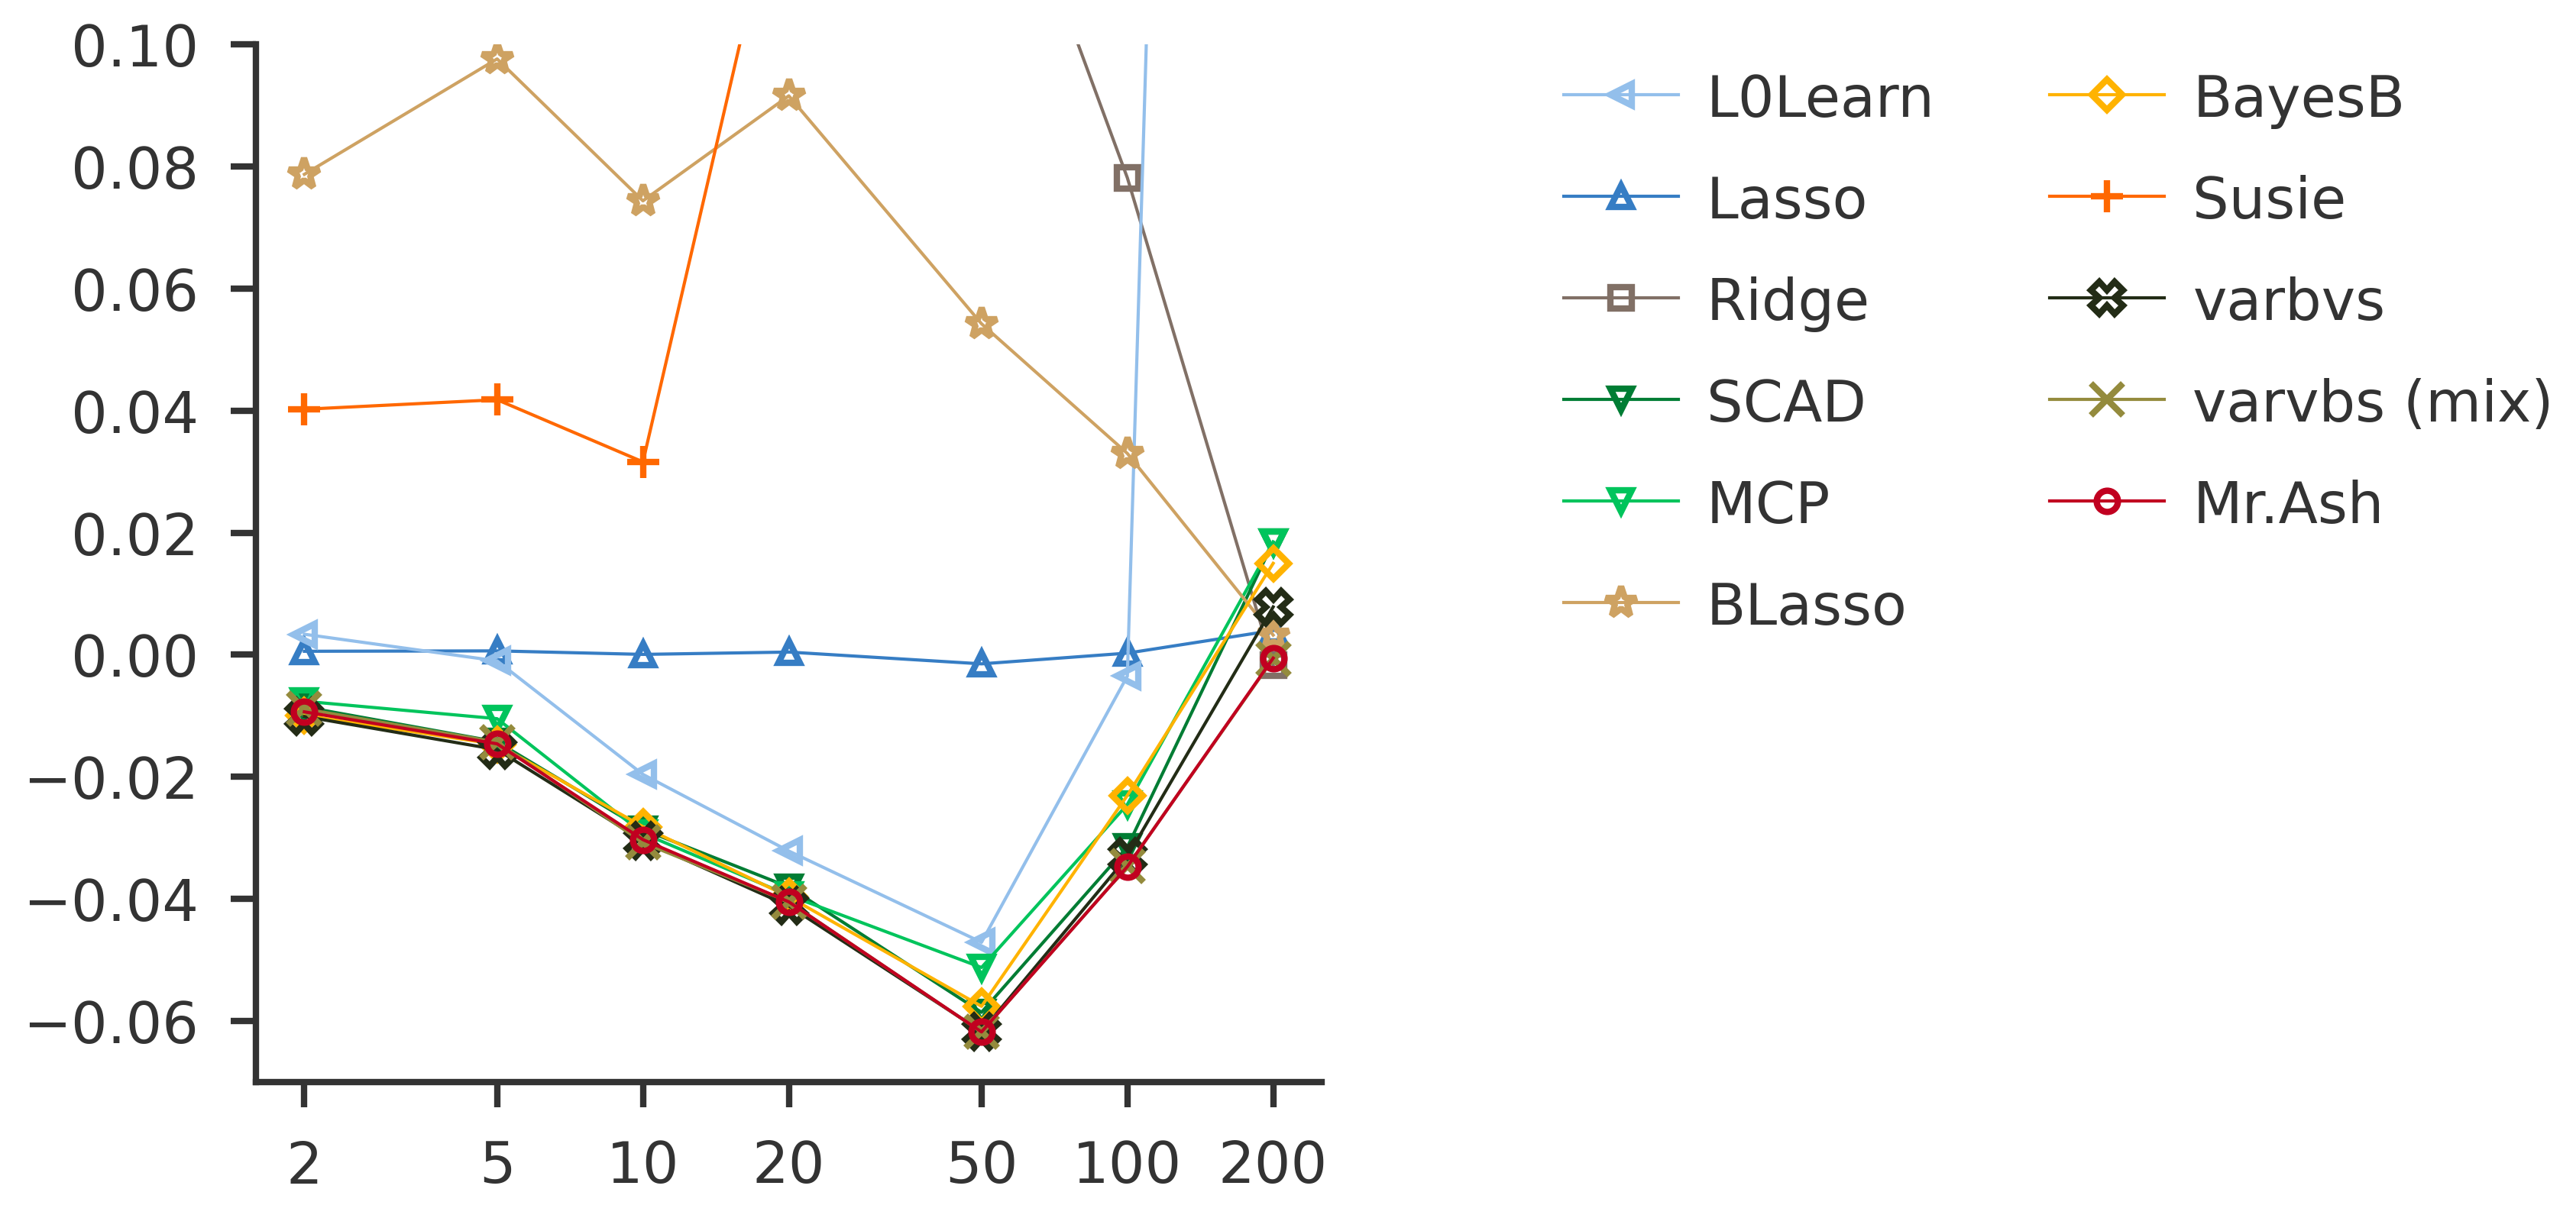

In [47]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)

xvals  = [max(1, int(x * dims[1])) for x in sfracs]
xscale = 'log10'
yscale = 'linear'

methods = ["l0learn", "lasso", 
           #"lasso_1se", 
           "ridge", 
           #"elastic_net", 
           #"elastic_net_1se", 
           "scad", "mcp",
           "blasso", "bayesb", 
           "susie", 
           "varbvs", "varbvsmix", 
           "mr_ash", #"mr_ash_init"
          ]

ridge_condition = f"$(fit) == elastic_net"

for method in methods:
    score = [0 for x in sfracs]
    method_condition = f"$(fit) == {method}"
    pve_condition    = f"$(simulate.pve) == 0.95"
    for i, sfrac in enumerate(sfracs):
        sfrac_condition = f"$(simulate.sfrac) == {sfrac}"
        dfselect = dscutils.select_dfrows(dscout, [method_condition, pve_condition, sfrac_condition])
        dfridge  = dscutils.select_dfrows(dscout, [ridge_condition,  pve_condition, sfrac_condition])
        score[i] = np.mean(dfselect['score1'].to_numpy()) - np.mean(dfridge['score1'].to_numpy())

    # Plot xvals vs score
    pm = plot_meta.regression_methods()[method]
    xx = mpl_utils.scale_array(xvals, xscale)
    yy = mpl_utils.scale_array(score, yscale)
    ax1.plot(xx, yy, label = pm.label,
             color = pm.color, lw = pm.linewidth / 2, ls = pm.linestyle,
             marker = pm.marker, ms = pm.size / 1.2, mec = pm.color, mfc = pm.facecolor,
             mew = pm.linewidth, zorder = pm.zorder
            )

#mpl_utils.set_ymax(ax1, 1.5, scale = yscale)
mpl_utils.set_xticks(ax1, scale = xscale, tickmarks = xvals)
#mpl_utils.set_yticks(ax1, scale = yscale, kmin = 2, kmax = 4)
mpl_utils.decorate_axes(ax1, hide = ["top", "right"], ticklimits = False)
ax1.set_ylim(mpl_utils.scale_list([-0.07, 0.1], yscale))

ax1.legend(bbox_to_anchor = (1.2, 1.), loc = "upper left", ncol = 2, handlelength = 2)

plt.show()

In [19]:
dscutils.select_dfrows(dscout, ["$(fit) == ridge", "$(simulate.sfrac) == 0.05", pve_condition])

,DSC,simulate,simulate.dims,simulate.se,simulate.sfrac,simulate.pve,fit,mse.err,score1
2242,1,indepgauss,"(500,200)",3.063747,0.05,0.5,ridge,13.188368,1.185339
2256,2,indepgauss,"(500,200)",3.279109,0.05,0.5,ridge,14.205955,1.149422
2270,3,indepgauss,"(500,200)",2.913003,0.05,0.5,ridge,12.058111,1.192062
2284,4,indepgauss,"(500,200)",4.268148,0.05,0.5,ridge,23.866936,1.144614
2298,5,indepgauss,"(500,200)",2.345804,0.05,0.5,ridge,7.631375,1.177632
2312,6,indepgauss,"(500,200)",2.429442,0.05,0.5,ridge,6.899844,1.081217
2326,7,indepgauss,"(500,200)",2.955638,0.05,0.5,ridge,12.449179,1.193766
2340,8,indepgauss,"(500,200)",2.070918,0.05,0.5,ridge,6.169530,1.199397
2354,9,indepgauss,"(500,200)",2.680845,0.05,0.5,ridge,9.318532,1.138681
2368,10,indepgauss,"(500,200)",3.606883,0.05,0.5,ridge,19.362062,1.219955


In [7]:
dscutils.select_dfrows(dscout, ["$(fit) == varbvs", "$(simulate.sfrac) == 0.5", pve_condition])

,DSC,simulate,simulate.dims,simulate.se,simulate.sfrac,simulate.pve,fit,mse.err,score1
565,1,indepgauss,"(500,200)",9.506717,0.5,0.5,varbvs,117.032824,1.137950
579,2,indepgauss,"(500,200)",9.559303,0.5,0.5,varbvs,114.696509,1.120338
593,3,indepgauss,"(500,200)",9.296320,0.5,0.5,varbvs,109.595596,1.126122
607,4,indepgauss,"(500,200)",10.970291,0.5,0.5,varbvs,136.690542,1.065740
621,5,indepgauss,"(500,200)",9.976602,0.5,0.5,varbvs,141.457787,1.192150
635,6,indepgauss,"(500,200)",8.387438,0.5,0.5,varbvs,104.587004,1.219297
649,7,indepgauss,"(500,200)",10.223867,0.5,0.5,varbvs,135.044155,1.136639
663,8,indepgauss,"(500,200)",8.595523,0.5,0.5,varbvs,117.749796,1.262431
677,9,indepgauss,"(500,200)",10.592592,0.5,0.5,varbvs,145.671409,1.139423
691,10,indepgauss,"(500,200)",10.087358,0.5,0.5,varbvs,154.179840,1.230939
